In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import metpy
import numpy as np
from working.sea_breeze.load_model_d import load_barra_wind_data, load_barra_variable, load_barra_static
import datetime as dt
import pandas as pd

from working.sea_breeze.load_obs import load_half_hourly_stn_obs
from working.sea_breeze.utils import interp_model_level_to_z

In [2]:
from climtas.nci import GadiClient
client = GadiClient()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45901 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45901/status,
Dashboard: /proxy/45901/status,Workers: 1
Total threads: 1,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36133,Workers: 1
Dashboard: /proxy/45901/status,Total threads: 1
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33043,Total threads: 1
Dashboard: /proxy/33429/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:33075,


In [3]:
# stn_obs = xr.open_dataset("/g/data/w40/clv563/BoM_data_202409/half_hourly_data_netcdf/AWS-data-VIC.nc").sel(time=slice("2023-12-01 00:00","2024-02-29 23:00"))

# u,v = metpy.calc.wind_components(
#     stn_obs.wspd.metpy.convert_units("m/s"),
#     stn_obs.wdir * metpy.units.units.deg)
# stn_obs["u"] = u
# stn_obs["v"] = v

# stn_obs

stn_obs = load_half_hourly_stn_obs("VIC", slice("2023-12-01 00:00","2024-02-29 23:00"))

,name,bmid,lati,long
station,,,,
21,b'YARRAWONGA ...,81124.0,-36.029400,146.030502
23,b'RUTHERGLEN RESEARCH ...,82039.0,-36.104801,146.509399
24,b'WANGARATTA AERO ...,82138.0,-36.420502,146.305603
25,b'HUNTERS HILL ...,82139.0,-36.213699,147.539505
26,b'MOUNT BULLER ...,83024.0,-37.145000,146.439407
27,b'FALLS CREEK ...,83084.0,-36.870800,147.275497
28,b'MOUNT HOTHAM ...,83085.0,-36.977200,147.134201
29,b'OMEO ...,83090.0,-37.101700,147.600800
30,b'GABO ISLAND LIGHTHOUSE ...,84016.0,-37.567902,149.915802


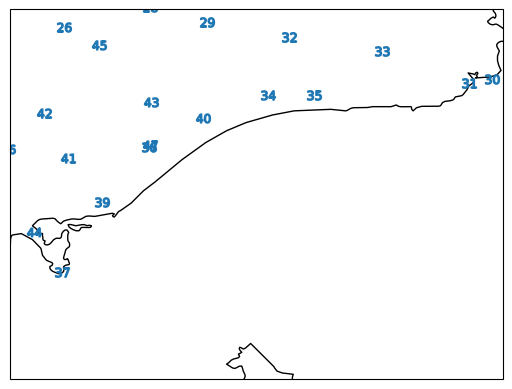

In [4]:
lat_bnds=[-40,-37]
lon_bnds=[146,150]

ax=plt.axes(projection=ccrs.PlateCarree())
[plt.plot(stn_obs.long.sel(station=i),stn_obs.lati.sel(station=i)
          ,ls="none",marker="$"+str(i)+"$",color="tab:blue",ms=10) for i in range(stn_obs.station.shape[0])]
ax.coastlines()
ax.set_ylim(lat_bnds)
ax.set_xlim(lon_bnds)

stn_inds = stn_obs.long >= lon_bnds[0]
stn_obs[["name","bmid","lati","long","station"]].isel(station=stn_inds).to_dataframe()

In [ ]:
barra = load_barra_wind_data(
    ["uas","ua1500m"], 
    ["vas","va1500m"], 
    ["ws","ws_1500m"], 
    "2023-12-01 00:00", "2024-02-29 23:59", "AUS-11", "1hr", slice(lat_bnds[0],lat_bnds[1]), slice(lon_bnds[0],lon_bnds[1]))

In [26]:
# barra_c = load_barra_wind_data(
#     ["uas","ua1500m"], 
#     ["vas","va1500m"], 
#     ["ws","ws_1500m"], 
#     "2024-01-28 00:00", "2024-01-30 23:59", "AUST-04", "1hr", slice(lat_bnds[0],lat_bnds[1]), slice(lon_bnds[0],lon_bnds[1]))

barra_c = xr.open_dataset("/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/vas/latest/vas_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_202401-202401.nc")

In [21]:
orog, lsm = load_barra_static("AUS-11", slice(lon_bnds[0],lon_bnds[1]), slice(lat_bnds[0],lat_bnds[1]))

In [22]:
#Data here downloaded using era5_download_google.ipynb
f = xr.open_dataset("/g/data/gb02/ab4502/era5_test.nc",chunks={"latitude":5,"longitude":5})

#Adjust geopotential to height above surface
g = 9.80665    #https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height#heading-Geopotentialheight
topo = xr.open_dataset("/g/data/gb02/ab4502/era5_static/raw_date-variable-static_2021_12_31_geopotential_static.nc")
topo = topo.squeeze().sel(longitude=f.longitude, latitude=f.latitude)["z"] / g
f["geopotential"] = (f["geopotential"] / g) - topo
f = f.rename({"geopotential":"geopotential_hgt_agl"})

f = f.isel(hybrid=slice(None,None,-1))

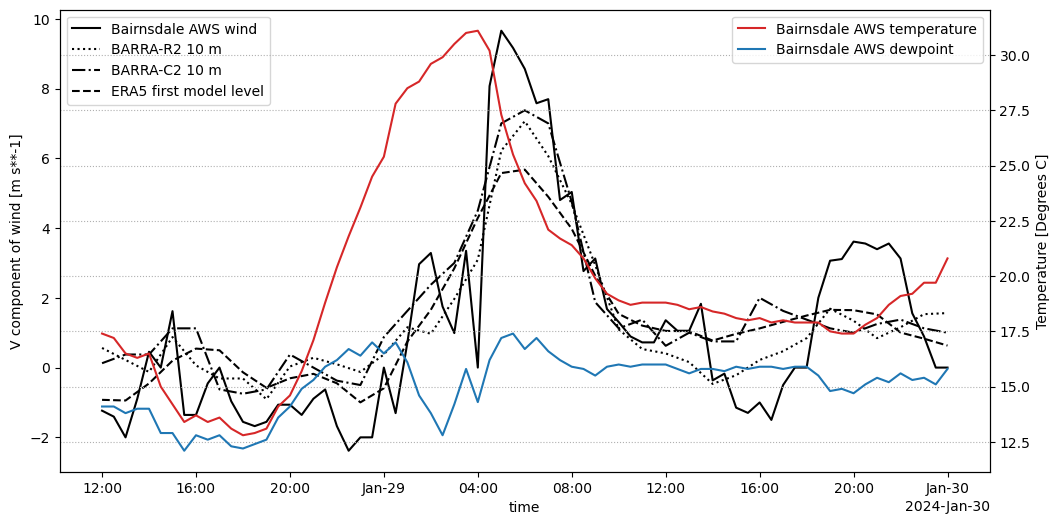

In [28]:
plt.figure(figsize=[12,6])
ax1=plt.axes()
stn_obs.sel(station=40).sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).v.plot(color="k",label="Bairnsdale AWS wind")

barra.sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati,method="nearest").vas.plot(color="k",ls=":",label="BARRA-R2 10 m")
barra_c.sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati,method="nearest").vas.plot(color="k",ls="-.",label="BARRA-C2 10 m")
f.sel(time=slice("2024-01-28 12:00","2024-01-30 00:00"),hybrid=137).sel(longitude=stn_obs.sel(station=40).long, latitude=stn_obs.sel(station=40).lati,method="nearest").v_component_of_wind.plot(color="k",ls="--",label="ERA5 first model level")

ax2=ax1.twinx()
stn_obs.sel(station=40).sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).temp.plot(color="tab:red",ax=ax2,label="Bairnsdale AWS temperature")
stn_obs.sel(station=40).sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).Tdew.plot(color="tab:blue",ax=ax2,label="Bairnsdale AWS dewpoint")
#plt.gca().axvline(pd.to_datetime("2024-01-29 06:00"),ls=":", color="k")
ax2.grid(ls=":")
ax2.set_ylabel("Temperature [Degrees C]")
ax1.set_title("")
ax2.set_title("")
ax1.legend(loc=2)
ax2.legend(loc=1)

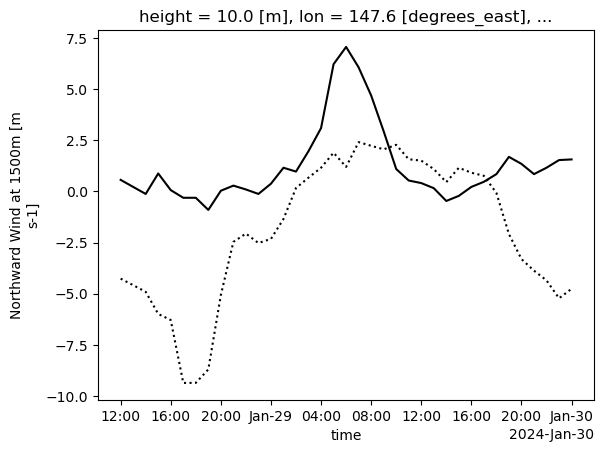

In [54]:
barra.sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati,method="nearest").vas.plot(color="k",ls="-")
barra.sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati,method="nearest").va1500m.plot(color="k",ls=":")

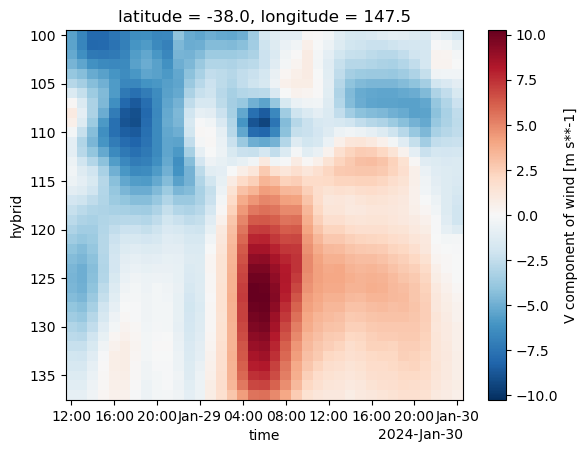

In [86]:
f.sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).sel(longitude=stn_obs.sel(station=40).long, latitude=stn_obs.sel(station=40).lati,method="nearest").v_component_of_wind.plot(y="hybrid")
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Time-height plot of ERA5 model level data')

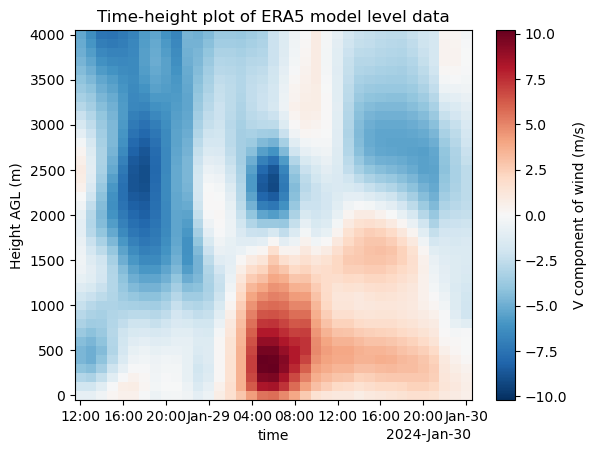

In [117]:
interp_era5 = interp_model_level_to_z(f["geopotential_hgt_agl"],f["v_component_of_wind"],"hybrid",np.arange(0,4100,100))
c=interp_era5.sel(longitude=stn_obs.sel(station=40).long, latitude=stn_obs.sel(station=40).lati,method="nearest").sel(time=slice("2024-01-28 12:00","2024-01-30 00:00")).\
plot(y="height",add_colorbar=False)
cb=plt.colorbar(c)
cb.set_label("V component of wind (m/s)")
plt.ylabel("Height AGL (m)")
plt.title("Time-height plot of ERA5 model level data")

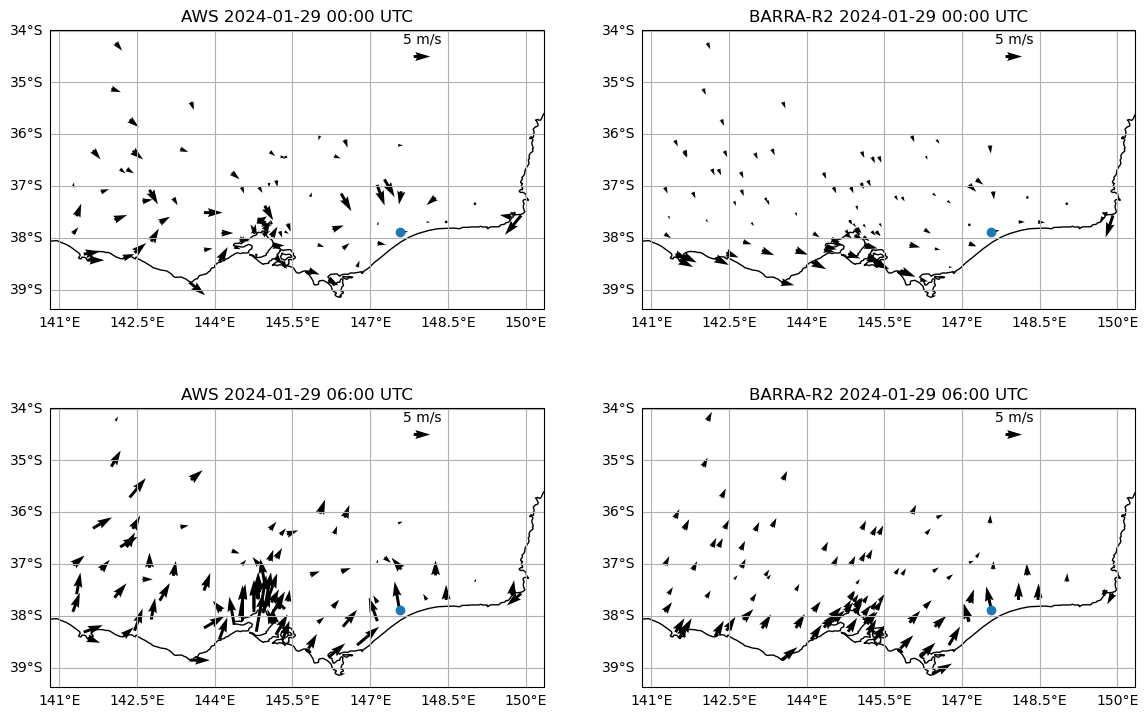

In [119]:
def plot_obs_q(stn_obs, t, ax):
    temp = stn_obs.sel(time=t)
    x = temp.long.values
    y = temp.lati.values
    u = temp.u.values
    v = temp.v.values
    
    q=ax.quiver(x,y,u,v,scale=150)
    plt.quiverkey(q,148,-34.5,5,"5 m/s",coordinates="data")
    ax.coastlines()
    ax.gridlines(draw_labels=["left","bottom"])

def plot_barra_q(barra, stn_obs, t, ax):
    temp = stn_obs.sel(time=t)
    x = xr.DataArray(temp.long.values, dims="points")
    y = xr.DataArray(temp.lati.values, dims="points")
    u = barra.sel(time=t,lon=x,lat=y,method="nearest").uas.values
    v = barra.sel(time=t,lon=x,lat=y,method="nearest").vas.values
    
    q=ax.quiver(x,y,u,v,scale=150)
    plt.quiverkey(q,148,-34.5,5,"5 m/s",coordinates="data")
    ax.coastlines()
    ax.gridlines(draw_labels=["left","bottom"])

plt.figure(figsize=[14,9])

plot_obs_q(stn_obs, "2024-01-29 00:00", plt.subplot(2,2,1,projection=ccrs.PlateCarree())); plt.title("AWS 2024-01-29 00:00 UTC")
plt.plot(147.566895, -37.881802, marker="o", color="tab:blue")
plot_barra_q(barra, stn_obs, "2024-01-29 00:00", plt.subplot(2,2,2,projection=ccrs.PlateCarree())); plt.title("BARRA-R2 2024-01-29 00:00 UTC")
plt.plot(147.566895, -37.881802, marker="o", color="tab:blue")

# plot_obs_q(stn_obs, "2024-01-29 03:00", plt.subplot(4,2,3,projection=ccrs.PlateCarree()))
# plot_barra_q(barra, stn_obs, "2024-01-29 03:00", plt.subplot(4,2,4,projection=ccrs.PlateCarree()))

plot_obs_q(stn_obs, "2024-01-29 06:00", plt.subplot(2,2,3,projection=ccrs.PlateCarree())); plt.title("AWS 2024-01-29 06:00 UTC")
plt.plot(147.566895, -37.881802, marker="o", color="tab:blue")
plot_barra_q(barra, stn_obs, "2024-01-29 06:00", plt.subplot(2,2,4,projection=ccrs.PlateCarree())); plt.title("BARRA-R2 2024-01-29 06:00 UTC")
plt.plot(147.566895, -37.881802, marker="o", color="tab:blue")

# plot_obs_q(stn_obs, "2024-01-29 09:00", plt.subplot(4,2,7,projection=ccrs.PlateCarree()))
# plot_barra_q(barra, stn_obs, "2024-01-29 09:00", plt.subplot(4,2,8,projection=ccrs.PlateCarree()))

In [19]:
print(stn_obs.sel(station=40).sel(time=stn_obs.sel(station=40)["u"].isnull())["time"])
print(stn_obs.sel(station=55).sel(time=stn_obs.sel(station=40)["u"].isnull())["time"])

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2024-02-22T17:30:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-02-22T17:30:00
Attributes:
    long_name:  Time
<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2024-02-22T17:30:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-02-22T17:30:00
Attributes:
    long_name:  Time


In [25]:
stn_obs.sel(station=55).name.values

array(b'MELBOURNE AIRPORT                                 ', dtype='|S50')

(-40.0, -37.0)

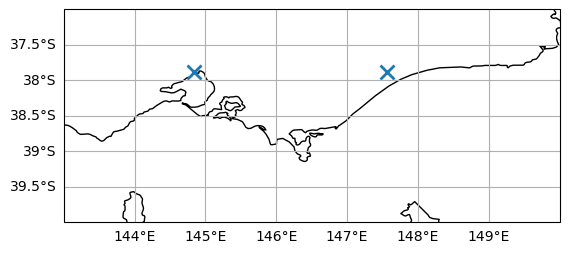

In [36]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.plot(stn_obs.sel(station=40).long.values,stn_obs.sel(station=40).lati.values, marker="x",color="tab:blue",ms=10,mew=2)
ax.plot(stn_obs.sel(station=55).long.values,stn_obs.sel(station=40).lati.values, marker="x",color="tab:blue",ms=10,mew=2)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"])
ax.set_xlim([143,150])
ax.set_ylim([-40,-37])

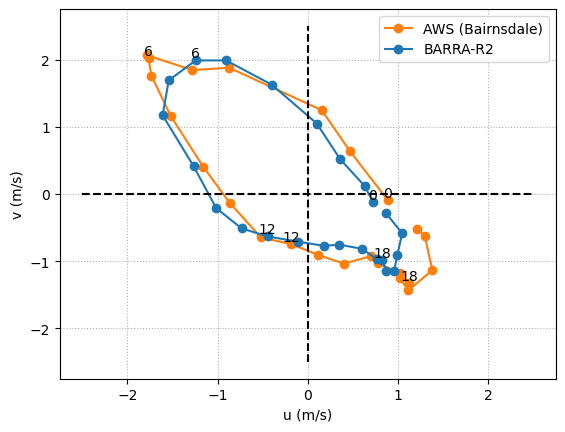

In [26]:
u_comp = stn_obs.sel(station=40)["u"].groupby("time.hour").mean()
v_comp = stn_obs.sel(station=40)["v"].groupby("time.hour").mean()
u_comp = u_comp - u_comp.mean()
v_comp = v_comp - v_comp.mean()
plt.plot(u_comp,v_comp,marker="o",label="AWS (Bairnsdale)",color="tab:orange")
[plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]

u_comp = barra.sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati, method="nearest")["uas"].groupby("time.hour").mean()
v_comp = barra.sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati, method="nearest")["vas"].groupby("time.hour").mean()
u_comp = u_comp - u_comp.mean()
v_comp = v_comp - v_comp.mean()
plt.plot(u_comp,v_comp,marker="o",color="tab:blue",ls="-",label="BARRA-R2")
[plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]

plt.gca().grid(ls=":")
plt.plot([0,0],[-2.5,2.5],color="k",ls="--")
plt.plot([-2.5,2.5],[0,0],color="k",ls="--")

plt.xlabel("u (m/s)")
plt.ylabel("v (m/s)")

plt.legend(loc=1)

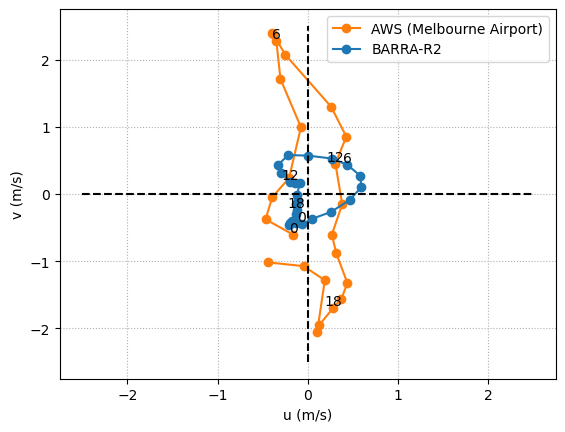

In [27]:
u_comp = stn_obs.sel(station=55)["u"].groupby("time.hour").mean()
v_comp = stn_obs.sel(station=55)["v"].groupby("time.hour").mean()
u_comp = u_comp - u_comp.mean()
v_comp = v_comp - v_comp.mean()
plt.plot(u_comp,v_comp,marker="o",label="AWS (Melbourne Airport)",color="tab:orange")
[plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]

u_comp = barra.sel(lon=stn_obs.sel(station=55).long, lat=stn_obs.sel(station=55).lati, method="nearest")["uas"].groupby("time.hour").mean()
v_comp = barra.sel(lon=stn_obs.sel(station=55).long, lat=stn_obs.sel(station=55).lati, method="nearest")["vas"].groupby("time.hour").mean()
u_comp = u_comp - u_comp.mean()
v_comp = v_comp - v_comp.mean()
plt.plot(u_comp,v_comp,marker="o",color="tab:blue",ls="-",label="BARRA-R2")
[plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]

plt.gca().grid(ls=":")
plt.plot([0,0],[-2.5,2.5],color="k",ls="--")
plt.plot([-2.5,2.5],[0,0],color="k",ls="--")

plt.xlabel("u (m/s)")
plt.ylabel("v (m/s)")

plt.legend(loc=1)

In [24]:
#Load the AMDAR data from Qinuo
amdar = xr.open_dataset("/g/data/gb02/ab4502/AMDAR/MelbourneAirport_interpolated.nc").sel(time=slice("2017-12-01 00:00","2018-02-28 23:59"))



Text(0.5, 0, 'Time (LST)')

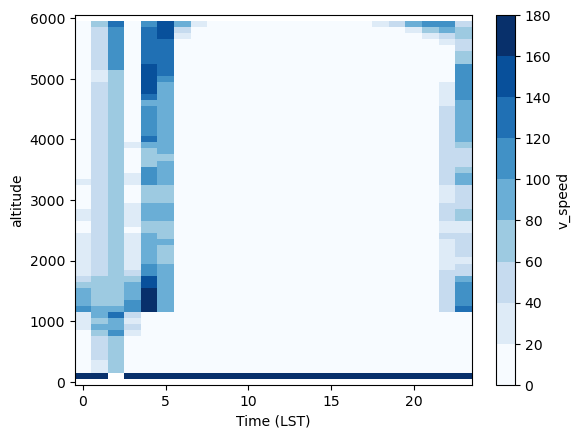

In [25]:
amdar.v_speed.isnull().groupby("time.hour").sum().plot(y="altitude",levels=10,cmap="Blues")
plt.xlabel("Time (LST)")

In [26]:
#Mask 2300-0400 hours LST following Qinuo's paper
amdar.loc[{"time":np.in1d(amdar.time.dt.hour,[1,2])}] = np.nan
amdar.loc[{"time":np.in1d(amdar.time.dt.hour,[22,23,0,3,4,5]),"altitude":slice(1000,6000)}] = np.nan

#I think the times are in LST (Local solar time?) so do an approximate conversion to UTC by subtracting 10 hours
amdar["time"] = pd.to_datetime(amdar.time) + dt.timedelta(hours=-10)

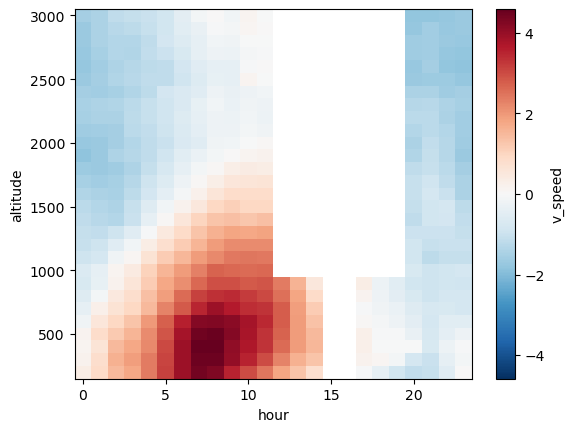

In [27]:
amdar.v_speed.groupby("time.hour").mean().sel(altitude=slice(200,3000)).plot(y="altitude")

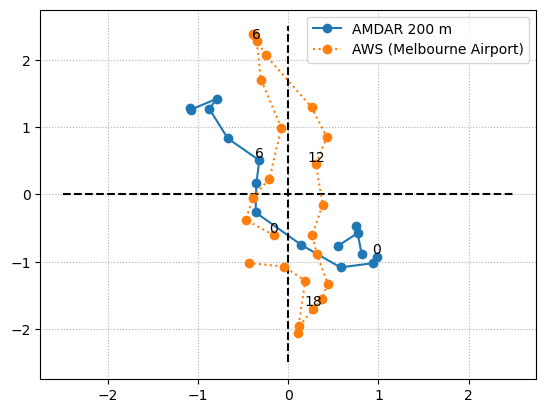

In [28]:
z=1500

u_comp = amdar.u_speed.sel(altitude=z).groupby("time.hour").mean()
v_comp = amdar.v_speed.sel(altitude=z).groupby("time.hour").mean()
u_comp = u_comp - u_comp.mean()
v_comp = v_comp - v_comp.mean()
plt.plot(u_comp,v_comp,marker="o",label="AMDAR 200 m")
[plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]];

plt.gca().grid(ls=":")
plt.plot([0,0],[-2.5,2.5],color="k",ls="--")
plt.plot([-2.5,2.5],[0,0],color="k",ls="--")

u_comp = stn_obs.sel(station=55)["u"].groupby("time.hour").mean()
v_comp = stn_obs.sel(station=55)["v"].groupby("time.hour").mean()
u_comp = u_comp - u_comp.mean()
v_comp = v_comp - v_comp.mean()
plt.plot(u_comp,v_comp,marker="o",label="AWS (Melbourne Airport)",ls=":")
[plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]];

plt.legend(loc=1)

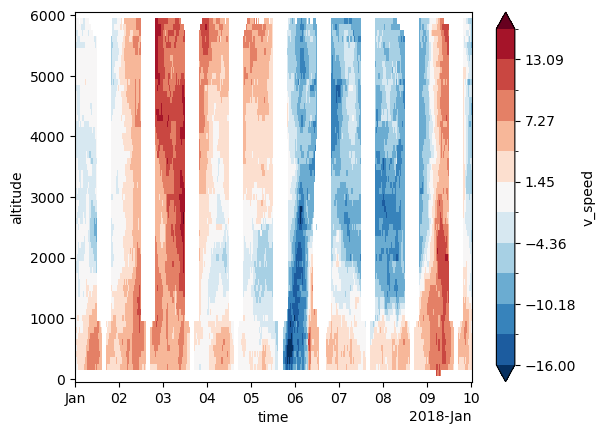

In [34]:
amdar.sel(time=slice("2018-01-01 00:00", "2018-01-10 00:00")).v_speed.plot(x="time",vmin=-16,vmax=16,cmap="RdBu_r",levels=12)